# Тема 2.3. Семантический нейросетевой анализ текста

2.3.1. Векторное представление единиц текста.  
**2.3.2. Обучение нейросетевой модели word2vec.**  
2.3.3. Нейросетевая модель torch.embedding.  
2.3.4. Анализ тематик электронных писем.  
2.3.5. Анализ семантической близости двух текстов.  


In [1]:
# all imports in one cell
from typing import List, Dict, Tuple
import numpy as np
import torch
from torch.autograd import Variable
import torch.functional as F
import torch.nn.functional as F

import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from string import punctuation

import graphviz
from IPython import display
import warnings


In [2]:
# some common settings
plt.style.use('ggplot')
graphviz.set_jupyter_format('svg')
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

> "A word is characterized by the company it keeps"  
[John Rupert Firth](https://en.wikipedia.org/wiki/John_Rupert_Firth)  

**Дистрибутивная гипотеза** - лингвистические единицы, встречающиеся в схожих контекстах, имеют близкие значения (значение слова определяется словами, с которыми оно употребляется).  
Например слова "чай" и "кофе" семантически близки так как употребляются вместе со словами "ложка", "чашка".  
  
**Языковая модель (статистическая)** - распределение вероятностей по последовательностям слов. Нейросетевые модели, обученные предсказывать слово с учетом контекста. Например: "Мама мыла Х", где слово "раму" имеет вероятность больше, чем слово "папу".  
  
**Word2Vec (word to vector)** - нейросетевая языковая модель обучения без учителя, получает на вход слово, на выходе - вектор фиксированной размерности. Задача модели - представить слова таким вектором, чтобы слова со схожим смыслом (контекстом) были близки, а с различающимся - далеки друг от друга.  
Word2Vec обучается на больших объемах текстов (текстах новостей, википедии), что позволяет получить обширные "знания" (языковую интуицию). В результате модель можно переиспользовать на разных задачах.  
  
**Embedding ([вложение](https://ru.wikipedia.org/wiki/Вложение))** - векторное представление слова/текста (результат на выходе из модели).  
  


## Обучение собственной модели  word2vec

Обучим собственную модель на небольшом корпусе текстов. 

### Корпус текстов.

In [4]:
tokenizer = WhitespaceTokenizer()


def delete_punctuation(text: str) -> str:
    """
    Удаление стоп-слов.

    Args:
        text (str): Исходный текст.
    Returns:
        str: Обработанный текст.
    """

    return ' '.join([t for t in tokenizer.tokenize(text) if t not in punctuation])


corpora = [
    'он - король',
    'она - королева',
    'он - мужчина',
    'она - женщина',
    'Москва это столица России',
    'Париж это столица Франции',
    'Берлин это столица Германии',
]

text_processors = [
    str.lower,
    delete_punctuation,
]

for proc in text_processors:
    for i, text in enumerate(corpora):
        corpora[i] = proc(text)

print(*corpora, sep='\n')

он король
она королева
он мужчина
она женщина
москва это столица россии
париж это столица франции
берлин это столица германии


### Создание словаря.

Первый шаг обучения модели - создание своего словаря.  
Расширение словаря в модели Word2vec не предусматривается, в "классическом" варианте модель не может работать с несловарнымии словами.  
Для того чтобы обойти это ограничение, можно обучить модель на побуквенных н-граммах (как это сделали [FastText](https://fasttext.cc) )  

In [5]:
tokenized_corpora = [tokenizer.tokenize(text) for text in corpora]
print(tokenized_corpora)

[['он', 'король'], ['она', 'королева'], ['он', 'мужчина'], ['она', 'женщина'], ['москва', 'это', 'столица', 'россии'], ['париж', 'это', 'столица', 'франции'], ['берлин', 'это', 'столица', 'германии']]


In [6]:
vocabulary = set([tokens for sentence in tokenized_corpora for tokens in sentence])

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

print('word2idx:', word2idx)
print('idx2word:', idx2word)
print('vocabulary_size:', vocabulary_size)

word2idx: {'париж': 0, 'мужчина': 1, 'столица': 2, 'франции': 3, 'россии': 4, 'это': 5, 'москва': 6, 'берлин': 7, 'она': 8, 'король': 9, 'он': 10, 'женщина': 11, 'королева': 12, 'германии': 13}
idx2word: {0: 'париж', 1: 'мужчина', 2: 'столица', 3: 'франции', 4: 'россии', 5: 'это', 6: 'москва', 7: 'берлин', 8: 'она', 9: 'король', 10: 'он', 11: 'женщина', 12: 'королева', 13: 'германии'}
vocabulary_size: 14


**Дистрибутивная гипотеза** - лингвистические единицы, встречающиеся в схожих контекстах, имеют близкие значения (значение слова определяется словами, с которыми оно употребляется).  
Например слова "чай" и "кофе" семантически близки так как употребляются вместе со словами "ложка", "чашка".  

Нам нужно создать наборы центральных слов (чай и кофе в примере выше) и слов контекста (ложка, чашка).  
Для обучения модели используется искусственно созданный корпус.  
Размер контекстного окна (`N`)- максимальное количество слов до и после центрального. Например для `N=2` для строки "москва столица россии", мы получим следующий набор:  
Для центрального слова `москва` - `['столица', 'россии']`  
Для центрального слова `столица` - `['москва', 'россии']`  
  
На практике (когда модель обучается на объемных корпусах) такая обработка производится на лету, мы же сделаем этот шаг отдельно.  

In [7]:
cw_size = 2 # context window size - размер контекстного окна
idx_pairs = []

for sentence in tokenized_corpora:
    indices = [word2idx[word] for word in sentence]
    # рассматриваем каждое слово как центральное
    for center_word_i in range(len(indices)):
        # для каждой позиции окна
        for w in range(-cw_size, cw_size + 1):
            context_word_i = center_word_i + w
            if (context_word_i >= 0
                and context_word_i < len(indices)
                and center_word_i != context_word_i):
                context_word_idx = indices[context_word_i]
                idx_pairs.append((indices[center_word_i], context_word_idx))

# для удобства переведем в numpy.array
idx_pairs = np.array(idx_pairs)

In [8]:
print(f'для текста: "{corpora[4]}", получим:', end='\n\n')
print('center', 'context', sep='\t')
for p in idx_pairs[8:16]:
    print(*[idx2word[i] for i in p], sep='\t')

для текста: "москва это столица россии", получим:

center	context
москва	это
москва	столица
это	москва
это	столица
это	россии
столица	москва
столица	это
столица	россии



Используются 2 архитектуры нейронных сетей - CBOW (Continuous Bag Of Word) и Skip-gram.  
  
## CBOW (Continuous Bag Of Word)  
Получить самое вероятное центральное слово при условии заданного контекста.  
$P(center|context, \theta)$  
Получить вероятностное распределение для пары "центральное слово = слово контекста" с некоторым параметром $\theta$ (например $P(москва | столица)$)  

In [5]:
%%javascript
IPython.load_ipython_extensions([
  "nb-mermaid/nb-mermaid"
]);

<IPython.core.display.Javascript object>

```mermaid
graph TD here[this page] --> bookmarklet(use bookmarklet) bookmarklet --> make here --> pip(pip) here --> clone pip --> installed clone(clone) --> installed clone --> fork(fork) fork --> profit((profit)) make(make diagrams) --> profit installed --> make
```

In [2]:
dot = """
digraph G{
    rankdir=LR
    node [shape=box]

    w1 [label="w_i-2"]
    w2 [label="w_i-1"]
    w4 [label="w_i+1"]
    w5 [label="w_i+2"]
    w3 [label="w_i"]
    e [label=""]
    e -> w3
    w1 -> e
    w2 -> e
    w4 -> e
    w5 -> e
}
"""

print('Схематично модель CBOW можно представить так:')
display.display_svg(graphviz.Source(dot))

Схематично модель CBOW можно представить так:


AttributeError: 'function' object has no attribute 'display_svg'

## Skip-gram  
Для заданного центрального слова получить список слов контекста (инверсия CBOW).  
$P(context|center, \theta)$  
  
Мы будем реализовывать нашу модель на skip-gram. Давайте разберем подробнее.  
Задача - получить максимум для всех пар контекст/центр.  
$max \prod _{center} \prod _{context} P(context|center; \theta)$  
  
Сумма вероятностей = 1, значит вероятность для несуществующих пар контекст/центр будет близка к 0. Нейронные сети минимизирую функцию потерь, а значит нам нужен $\min$, а не $\max$. Применим некоторые трансформации:  
$\min _{\theta} - \log \prod _{center} \prod _{context} P(context | center, \theta)$
  
Заменим произведение логарифмов их суммой ($\log(a * b) = \log(a) + \log(b)$) и поделим на количество пар ($T$).  
$loss = - \frac {1} {T} \sum _{center} \sum _{context} \log P(context|center, \theta)$  
  
  
$P(context|center) = \frac {\exp (u ^{T} _{context} v _{center})} {\sum _{w \in vocab} \exp(u ^{T} _{w} v _{center})}$  
  
где:  
$\frac {\exp(.)} {\sum \exp(.)}$ - softmax  
  
$u ^{T} _{context} v _{center}$ - скалярное произведение векторов центрального ($v$) и контекстного ($u$) слов.  
  
$\sum _{w \in vocab}$ - итерация по всему словарю  
  
$u ^{T} _{w} v _{center}$ - вычисление сходства для заданного центрального слова и каждого слова словаря (использованного как слово контекста).  
  
Для каждой пары центр/контекст мы вычисляем оценку близости и делим на сумму всех возможных оценок близости заданного центрального слова и всех слов словаря (для определения относительной величины оценки близости в числителе). Softmax гарантирует что значения будут находиться в диапазоне от 0 до 1.  


Skip-gram - инверсия CBOW:


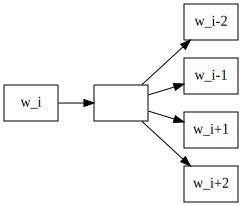

In [10]:
dot = """
digraph G{
    rankdir=LR
    node [shape=box]

    w1 [label="w_i-2"]
    w2 [label="w_i-1"]
    w4 [label="w_i+1"]
    w5 [label="w_i+2"]
    w3 [label="w_i"]
    e [label=""]
    w3 -> e
    e -> w1
    e -> w2
    e -> w4
    e -> w5
}
"""

print('Skip-gram - инверсия CBOW:')
display.display_svg(graphviz.Source(dot))

In [11]:
def get_input_layer(word_idx: int,
                    voc_size: int = vocabulary_size
                    ) -> torch.Tensor:
    """
    One-hot кодирование слова.

    Выдает вектор длиной `voc_size`, значения которого равны 0,
    за исключением `word_idx` = 1.

    Args:
        word_idx (int): индекс кодируемого слова
        voc_size: (int, optional): размер словаря.

    Returns:
        torch.Tensor: бинарный вектор.

    """

    x = torch.zeros(voc_size).float()
    x[word_idx] = 1.0
    return x


get_input_layer(2, 4)

tensor([0., 0., 1., 0.])

In [28]:
# Скрытый слой 
# матрица весов W1 - для вычисления скрытого представления вектора v (центрального слова)
# выдает вектор размером embedding_dims
# матрица W1 имеет размер [embedding_dims, vocabulary_size]
# в каждой колонке W1 хранится вектор для каждого слова из словаря

embedding_dims = 5
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)

# Выходной слой
# должен иметь vocabulary_size нейронов так как он генерирует вероятности для каждого слова словаря.
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)

num_epochs = 200
learning_rate = 0.001

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)

        # софтмакс
        log_softmax = F.log_softmax(z2, dim=0)

        # функция потерь
        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item()
        loss.backward()

        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()

    if epo % 10 == 0:
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

Loss at epo 0: 4.653172872568431
Loss at epo 10: 4.241988020507913
Loss at epo 20: 3.910935903850355
Loss at epo 30: 3.6373354510257117
Loss at epo 40: 3.407521368641602
Loss at epo 50: 3.212881990169224
Loss at epo 60: 3.047446501882453
Loss at epo 70: 2.9065199494361877
Loss at epo 80: 2.7860358749565326
Loss at epo 90: 2.6823853434700715
Loss at epo 100: 2.5924523370830634
Loss at epo 110: 2.5136657898363315
Loss at epo 120: 2.4439793150675926
Loss at epo 130: 2.381794873821108
Loss at epo 140: 2.3258725114558874
Loss at epo 150: 2.2752445010762465
Loss at epo 160: 2.2291447928077295
Loss at epo 170: 2.1869590392238214
Loss at epo 180: 2.1481875063557374
Loss at epo 190: 2.112416204653288


In [29]:
def similarity(v: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
  """Вычисление меры близости."""
  return torch.dot(v,u) / (torch.norm(v)*torch.norm(u))

In [37]:
# {word: [(word, similarity)]}
results: Dict[str, List[Tuple[str, float]]] = {}

for w1 in vocabulary:
    results[w1] = []
    for w2 in vocabulary:
        w1v = torch.matmul(W1, get_input_layer(word2idx[w1]))
        w2v = torch.matmul(W1, get_input_layer(word2idx[w2]))
        d = similarity(w1v, w2v).item()
        results[w1].append((w2, d))

    results[w1] = sorted(results[w1], key=lambda item: item[1], reverse=True)

col_width = 15
print(*[c.ljust(col_width) for c in ['Слово', 'Сосед', 'Расстояние']])
print('-'*col_width*3)

for w1 in results:
    for i in range(3):
        d = round(results[w1][i][1], 2)
        print(w1.ljust(col_width), results[w1][i][0].ljust(col_width), d)
    print()


Слово           Сосед           Расстояние     
---------------------------------------------
париж           париж           1.0
париж           берлин          0.81
париж           женщина         0.65

мужчина         мужчина         1.0
мужчина         она             0.47
мужчина         король          0.33

столица         столица         1.0
столица         франции         0.95
столица         германии        0.88

франции         франции         1.0
франции         германии        0.97
франции         столица         0.95

россии          россии          1.0
россии          германии        0.93
россии          франции         0.86

это             это             1.0
это             она             0.63
это             москва          0.4

москва          москва          1.0
москва          берлин          0.74
москва          париж           0.59

берлин          берлин          1.0
берлин          женщина         0.86
берлин          париж           0.81

она             она

# Выводы

1. Модель Word2Vec позволяет представить слово/текст вектором чисел.  
2. Полученный вектор имеет фиксированную размерность и не зависит от размера словаря.  
3. Модель можно обучать на больших корпусах текстов, это позволит переиспользовать одну модель для разных задач (будет рассмотрено в следующих темах).  

# Дополнительные материалы.  
- [Mikolov, T., et al. Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781 (2013).](https://arxiv.org/abs/1301.3781)  
- [Mikolov, Tomas, et al. Exploiting similarities among languages for machine translation. arXiv preprint arXiv:1309.4168 (2013).](http://arxiv.org/abs/1309.4168)  